# Fitting DCE time series
In this example, we process DCE data from a mild-stroke patient. First we do a simple ROI analysis using the median subcortical grey matter signal, then we demonstrate how to perform a voxelwise analysis.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sepal import dce_fit, relaxivity, signal_models, water_ex_models, aifs, pk_models
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple ROI analysis
First, we analyse the data using the following steps:
- signal -> enhancement
- enhancement -> concentration
- fit concentration curve using the Patlak model

Start by defining the time points and loading the ROI data:

In [3]:
dt=39.6  # temporal resolution
t = dt * (np.arange(32) + 0.5);

#### Load the ROI data for tissue and the VIF:

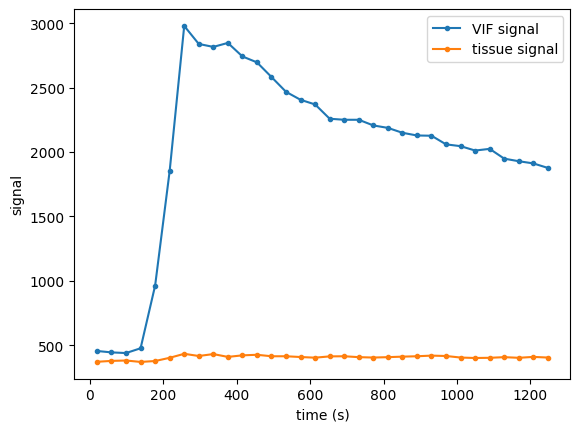

In [4]:
s_vif = np.load('./DCE_ROI_data/signal_vif.npy')  # signal
k_vif = np.load('./DCE_ROI_data/k_vif.npy')  # B1 correction factor (actual/nominal flip angle)
t1_vif = np.load('./DCE_ROI_data/t1_vif.npy')  # pre-contrast T1
s_tissue = np.load('./DCE_ROI_data/signal_tissue.npy')
k_tissue = np.load('./DCE_ROI_data/k_tissue.npy')
t1_tissue = np.load('./DCE_ROI_data/t1_tissue.npy')

hct = 0.395 # haematocrit

plt.plot(t, s_vif, '.-', label='VIF signal')
plt.plot(t, s_tissue, '.-', label='tissue signal')
plt.xlabel('time (s)')
plt.ylabel('signal')
plt.legend();

#### Calculate enhancement
Do this by creating a SigToEnh object and use the proc method to get enhancement. Use the first three points as the baseline.

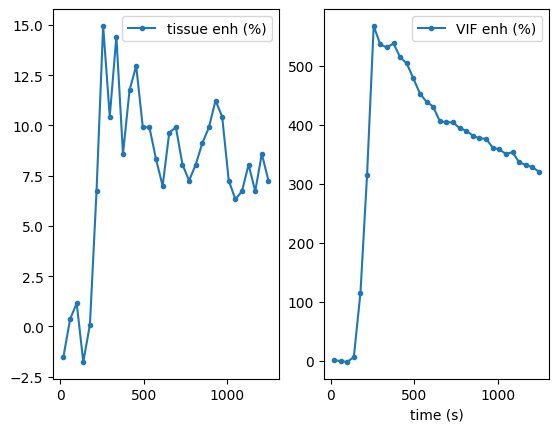

In [5]:
s_to_enh = dce_fit.SigToEnh(base_idx=[0, 1, 2])
enh_vif = s_to_enh.proc(s_vif)
enh_tissue = s_to_enh.proc(s_tissue)

fig, ax = plt.subplots(1,2)
ax[0].plot(t, enh_tissue, '.-', label='tissue enh (%)')
ax[1].plot(t, enh_vif, '.-', label='VIF enh (%)')
ax[1].set_xlabel('time (s)');
[a.legend() for a in ax.flatten()];

#### Calculate concentration
First define the relationship between concentration and relaxation rate:

In [6]:
c_to_r_model = relaxivity.CRLinear(r1=5.0, r2=7.1)

...and the relationship between relaxation rate and signal:

In [7]:
signal_model = signal_models.SPGR(tr=3.4e-3, fa=15, te=1.7e-3)

Now create an EnhToConc object and use the proc method to get concentration:

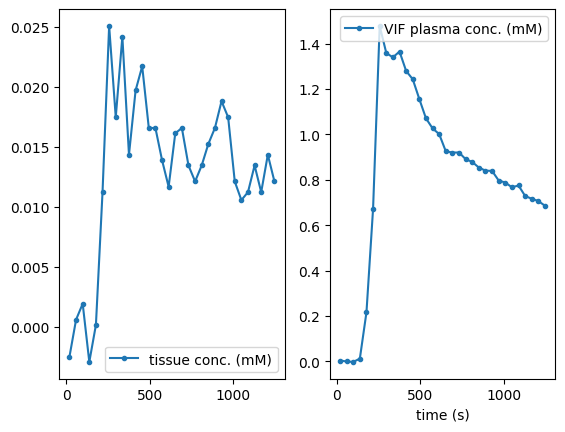

In [8]:
e_to_c = dce_fit.EnhToConc(c_to_r_model, signal_model)

C_t = e_to_c.proc(enh_tissue, t1_tissue, k_tissue)
c_p_vif = e_to_c.proc(enh_vif, t1_vif, k_vif) / (1-hct)

fig, ax = plt.subplots(1,2)
ax[0].plot(t, C_t, '.-', label='tissue conc. (mM)')
ax[1].plot(t, c_p_vif, '.-', label='VIF plasma conc. (mM)')
ax[1].set_xlabel('time (s)');
[a.legend() for a in ax.flatten()];

#### Fit the pharmacokinetic model to the concentration
First we need to create an AIF object based on the calculate VIF concentrations:

In [9]:
aif = aifs.PatientSpecific(t, c_p_vif)

...and a PKModel object:

In [10]:
pk_model = pk_models.Patlak(t, aif, bounds=((-1,-0.001),(1,1)))

Finally, we create a ConcToPKP object and use the proc method to fit the concentration data:

vp = 0.0139, ps = 0.000187


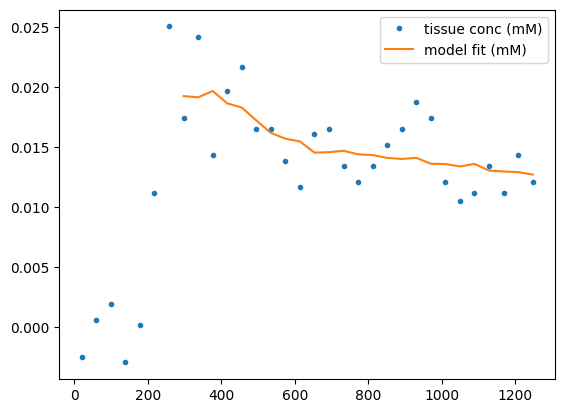

In [11]:
weights = np.concatenate([np.zeros(7), np.ones(25)]) # exclude first few points from fit
pkp_0 = [{'vp': 0.2, 'ps': 1e-4}] # starting parameters (multiple starting points can be specified if required)

conc_to_pkp = dce_fit.ConcToPKP(pk_model, pkp_0, weights)
vp, ps, C_t_fit = conc_to_pkp.proc(C_t)

plt.plot(t, C_t, '.', label='tissue conc (mM)')
plt.plot(t, C_t_fit, '-', label='model fit (mM)')
plt.legend();

print(f"vp = {vp:.4f}, ps = {ps:.6f}")
# Results using Matlab: vp = 0.0138, ps = 0.000188 min^-1

#### Fit using the linearised Patlak model
Method uses linear regression with two regressors: the AIF and the AIF integral.  
This method has faster performance than non-linear fit but is more robust than the classic "graphical" Patlak method.

vp = 0.0139, ps = 0.000187


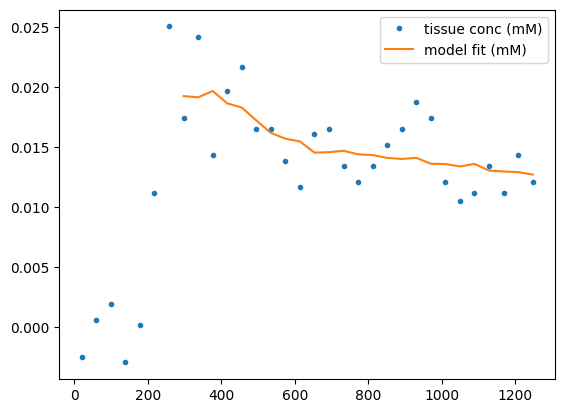

In [12]:
include = np.concatenate([np.zeros(7), np.ones(25)]) # exclude first few points from fit

conc_to_pkp_lin = dce_fit.PatlakLinear(t, aif, include=include)
vp, ps, C_t_fit = conc_to_pkp_lin.proc(C_t)

plt.plot(t, C_t, '.', label='tissue conc (mM)')
plt.plot(t, C_t_fit, '-', label='model fit (mM)')
plt.legend();

print(f"vp = {vp:.4f}, ps = {ps:.6f}")
# Results using Matlab: vp = 0.0138, ps = 0.000188 min^-1

## Fit data in signal space
Alternatively, we can fit the enhancement curve directly. To do this, we need to create a water_ex_model object, which determines the relationship between R1 in each tissue compartment and the exponential R1 components. We start by assuming the fast water exchange limit (as implicitly assumed above when estimating tissue concentration).
The results should be similar to fitting the concentration curve:

In [13]:
wxm = water_ex_models.FXL()

This time create an EnhToPKP object and use the proc method to fit the enhancement curve:

vp = 0.0139, ps = 0.000187


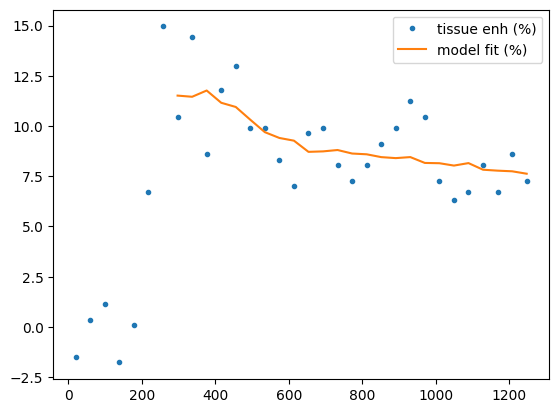

In [14]:
enh_to_pkp = dce_fit.EnhToPKP(hct, pk_model, t1_vif, c_to_r_model, wxm, signal_model, pkp_0, weights)

vp, ps, enh_fit = enh_to_pkp.proc(enh_tissue, k_tissue, t1_tissue)

plt.plot(t, enh_tissue, '.', label='tissue enh (%)')
plt.plot(t, enh_fit, '-', label='model fit (%)')
plt.legend();

print(f"vp = {vp:.4f}, ps = {ps:.6f}")

### Repeat the fit assuming *slow* BBB water exchange...
This time, we assume slow water exchange across the vessel wall. The result will be very different compared with fitting the concentration curve:

In [15]:
wxm_ntexl = water_ex_models.NTEXL()

Create a new EnhToPKP object using this water exchange model and repeat the fit:

vp = 0.0172, ps = 0.000102


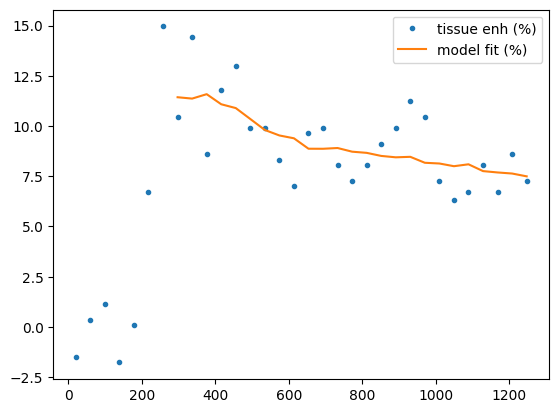

In [16]:
enh_to_pkp_ntexl = dce_fit.EnhToPKP(hct, pk_model, t1_vif, c_to_r_model, wxm_ntexl, signal_model, pkp_0, weights)

vp_ntexl, ps_ntexl, enh_fit_ntexl = enh_to_pkp_ntexl.proc(enh_tissue, k_tissue, t1_tissue)

plt.plot(t, enh_tissue, '.', label='tissue enh (%)')
plt.plot(t, enh_fit_ntexl, '-', label='model fit (%)')
plt.legend();

print(f"vp = {vp_ntexl:.4f}, ps = {ps_ntexl:.6f}")
# Results using Matlab: vp = 0.0172, ps = 0.000102

## Voxelwise fitting
The fitting objects created above can also be used to fit a 4D DCE image. Instead of the proc method, we use the proc_image method, and some of the arguments are images rather than single values/vectors. proc_image is a method of the base class (i.e. it's the same for all processing steps). It simply calls the subclass's proc method on each voxel in the image.  
Refer to proc_image and proc docstrings for further details.

#### Calculate enhancement image
The first argument is the input image, i.e. the re-aligned DCE signal image. This can be the path to a nii file or a np array.  
The mask argument provides a binary mask. Only voxels within the mask are processed.  
The dir argument indicates where to write the output image. If this is None (default), the results are not written to a file, only to variables.

In [ ]:
enh_4d = s_to_enh.proc_image(['./DCE_image_data/rDCE.nii'], mask='./DCE_image_data/betDCE3D0000_mask.nii', dir='.');

#### Calculate concentration
This time, the input image is the enhancement image (or array).  
Additional parameters must also be provided as images: T1 and k (B1+ correction) maps.  

In [ ]:
C_t_4d = e_to_c.proc_image(['./enh.nii'], arg_images=['./DCE_image_data/rT1.nii','./DCE_image_data/rk.nii'], mask='./DCE_image_data/betDCE3D0000_mask.nii', dir='.');

#### Fit pharmacokinetic model
This time, the input image is the tissue concentration image.  
The output images contain the pharmacokinetic parameters and the fitted concentrations.  
For speed, we use multiple cores.

In [ ]:
vp_3d, ps_3d, C_t_fit_4d = conc_to_pkp.proc_image('C_t.nii', mask='./DCE_image_data/betDCE3D0000_mask.nii', dir='.', n_procs=4);

#### Fit linear Patlak model

In [ ]:
vp_lin_3d, ps_lin_3d, C_t_fit_lin_4d = conc_to_pkp_lin.proc_image('C_t.nii', mask='./DCE_image_data/betDCE3D0000_mask.nii', dir='.', suffix="_lin", n_procs=4);